In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
import stockstats as ss

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score
from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV

import random

In [23]:
def profitable(x):
    fee = 0
    if x["change"] > fee:
        return 2
    elif x["change"] <= -fee:
        return 0
    else:
        return 1

In [18]:
'''stock = ss.StockDataFrame.retype(pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv')) #reads in data as StockDataFrame

stock = stock[1:].dropna() #removes all rows containing any NaN values

stock.to_csv("coinbase_minutely.csv")'''
stock = ss.StockDataFrame.retype(pd.read_csv('../Data/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv')) #reads in data as StockDataFrame

stock = stock[1:].dropna() #removes all rows containing any NaN values

print(len(stock))

951929


In [19]:
#data loading, preliminary cleaning, coercing
#stock = ss.StockDataFrame.retype(pd.read_csv('coinbase_minutely.csv')) #reads in data as StockDataFrame

#stock = stock[1:].dropna() #removes all rows containing any NaN values
#stock = stock.iloc[len(stock)-60*24*7:len(stock)]
#stock = stock.iloc[::-1] #reverses df into proper time series direction

stock = ss.StockDataFrame.retype(stock) #coerces df into StockDataFrame again

#calculates and appends TA indicators to stock

stock['macd']
stock['volume_delta']
stock['open_-1_r']
stock['cr']
stock['cr-ma1']
stock['cr-ma2']
stock['cr-ma3']
stock["rsi_6"]
stock["rsi_12"]
stock["wr_10"]
stock["cci"]
stock['tr']
stock['atr']
stock['dma']
stock['pdi']
stock['mdi']
stock['dx']
stock['adx']
stock['adxr']
stock['trix']
stock['trix_9_sma']
stock['vr']
stock.head()

#apply profitable function then clean dataset again
stock_month = stock
stock_month["profitable"] = stock.apply(profitable, axis=1)
stock_month["profitable"] = stock_month["profitable"].shift(-1) #shifts "profitable" target column up 1 so current days stats predict tomorrow's profitability 
stock_month = stock_month[1:len(stock_month.index)-1] #removes first & last entry that now has NaN "profitable" column
stock_month = stock_month[1:].dropna() #removes all rows containing any NaN values
print(len(stock))

c:\python36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
c:\python36\lib\site-packages\stockstats.py:387: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: np.fabs(x - x.mean()).mean())
c:\python36\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


951929


In [20]:
#create train-test sets, then std'ize and check lengths

y = stock_month["profitable"]
x = stock_month.drop(["profitable", "change"], axis=1) #move drop until after split to track data for backtesting

import random
RANDOM_STATE = 123
random.seed(RANDOM_STATE)
#x_train_raw,x_test_raw,y_train,y_test = train_test_split(stock_month,y,test_size = .3,random_state = RANDOM_STATE)
x_train = x.iloc[:int(len(stock_month)*.7)]
x_test = x.iloc[int(len(stock_month)*.7):]
y_train = y.iloc[:int(len(stock_month)*.7)]
y_test = y.iloc[int(len(stock_month)*.7):]

x_std_train = (x_train - x_train.mean())/x_train.std()
x_std_test = (x_test - x_test.mean())/x_test.std()

x_std_train = x_std_train.drop(["open","high","low","close","volume"], axis=1)
x_std_test = x_std_test.drop(["open","high","low","close","volume"], axis=1)

print(x_train.shape)
print(x_test.shape)
print(x.shape)
print(x_train.shape[0]+x_test.shape[0])
print(y_train.mean())
print(y_test.mean())

(666202, 55)
(285516, 55)
(951718, 55)
951718
1.0182572252860245
1.0409854438980652


In [21]:
print(type(x_train))
print(y_train.mean())
print(y_test.mean())

<class 'pandas.core.frame.DataFrame'>
1.0182572252860245
1.0409854438980652


c:\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished


Accuracy Score: 0.427804


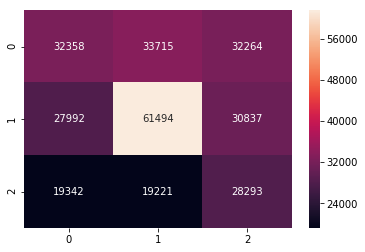

In [22]:
clf_rf = RandomForestClassifier(random_state = RANDOM_STATE, verbose=1)
clr_rf = clf_rf.fit(x_std_train,y_train)

predictions = clf_rf.predict(x_std_test)

ac = accuracy_score(predictions,y_test)
cm = confusion_matrix(predictions,y_test)

print('Accuracy Score: %f' % ac)
sns.heatmap(cm,annot = True,fmt = 'd')

#f1 = f1_score(predictions, y_test)
#type(predictions)
#print("F1 score: ", f1)

In [11]:
params = {'min_samples_leaf':range(1,20,2),
          'max_features':range(5,50,2),
          'warm_start':[True,False]
          }
rf_model = GridSearchCV(clf_rf, param_grid=params, n_jobs=-1, verbose=True)
rf_model = rf_model.fit(x_std_train,y_train)

c:\python36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 460 candidates, totalling 1380 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1380 out of 1380 | elapsed:  4.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy Score: 0.517378
F1 score:  0.43750000000000006
Best Params:  {'max_features': 5, 'min_samples_leaf': 1, 'warm_start': True}


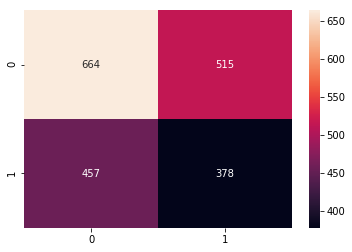

In [12]:
predictions = rf_model.predict(x_std_test)

ac = accuracy_score(predictions,y_test)
cm = confusion_matrix(predictions,y_test)

print('Accuracy Score: %f' % ac)
sns.heatmap(cm,annot = True,fmt = 'd')

f1 = f1_score(predictions, y_test)
#type(predictions)
print("F1 score: ", f1)
print("Best Params: ", rf_model.best_params_)

In [ ]:
params = {'n_estimators':range(1,11),
          'min_samples_leaf':range(7,13),
          'max_features':range(8,20),
          'warm_start':[True,False]
          }
rf_model = GridSearchCV(clf_rf, param_grid=params, n_jobs=-1, verbose=True)
rf_model = rf_model.fit(x_std_train,y_train)

Accuracy Score: 0.500000
F1 score:  0.542713567839196
Best Params:  {'max_features': 9, 'min_samples_leaf': 8, 'n_estimators': 1, 'warm_start': True}


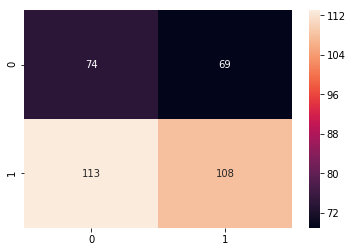

In [38]:
predictions = rf_model.predict(x_std_test)

ac = accuracy_score(predictions,y_test)
cm = confusion_matrix(predictions,y_test)

print('Accuracy Score: %f' % ac)
sns.heatmap(cm,annot = True,fmt = 'd')

f1 = f1_score(predictions, y_test)
#type(predictions)
print("F1 score: ", f1)
print("Best Params: ", rf_model.best_params_)

In [13]:
answers_df = pd.DataFrame(
    {'close': list(x_test["close"]),
     'predictions': list(predictions)
    })

answers_df.to_csv("answers_minutely.csv")

In [29]:
answers_df.to_csv("answers_daily.csv")

In [35]:
print(type(range(1,5)))

<class 'range'>
